Ce notebook contient un traitement effectué sur trois bases de données, la première provenant de l'INSEE et contenant des informations sur le taux de pauvereté par arrondissement Parisien. La deuxième base contient des informations sur la distribution des logements sociaux à Paris. Finalement, la troisième qui provient de la région Ile-de-France présente le nombre et le type de commerces dans différents arrondissements de Paris. Le but de ce notebook est de présenter quelques statistiques descriptives et de préparer les variables "taux de pauvereté", "nombre de logements sociaux" et "nombre de commerces" pour la régression.

## Importation de la base de l'INSEE sur la distribution des revenus

In [1]:
%%capture 
#pip install -r requirements.txt
!pip install pynsee

In [2]:
from pynsee.download import download_file
import requests
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import geopandas as gpd
from shapely.geometry import Point
import folium
from IPython.display import display



/home/yasmine/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/yasmine/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/yasmine/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (

Nous téléchargeons, sauvegardons et décompressons un fichier ZIP provenant de l'INSEE afin de récuperer la base "FILO2017_DISP_Pauvres_COM.xlsx"

In [2]:
url = "https://www.insee.fr/fr/statistiques/fichier/4291712/indic-struct-distrib-revenu-2017-COMMUNES.zip"
dest_zip = "baseInsee.zip"
response = requests.get(url)
if response.status_code == 200:
    with open(dest_zip, "wb") as f:
        f.write(response.content)
    print("Téléchargement réussi : fichier sauvegardé sous", dest_zip)
else:
    print("Erreur lors du téléchargement :", response.status_code)
    exit()

destination_dir = "./data/insee"
os.makedirs(destination_dir, exist_ok=True) 
print("Décompression du fichier...")
with zipfile.ZipFile(dest_zip, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)
print(f"Décompression terminée dans le dossier : {destination_dir}")
print("Lecture des fichiers dans le répertoire décompressé :")
for root, dirs, files in os.walk(destination_dir):
    for file in files:
        print(f"- {file}")

Téléchargement réussi : fichier sauvegardé sous baseInsee.zip
Décompression du fichier...
Décompression terminée dans le dossier : ./data/insee
Lecture des fichiers dans le répertoire décompressé :
- FILO2017_TRDECILES_DEC_COM.xlsx
- FILO2017_DEC_Pauvres_COM.xlsx
- FILO2017_DISP_Pauvres_COM.xlsx
- FILO2017_TRDECILES_DISP_COM.xlsx
- FILO2017_DEC_COM.xlsx
- FILO2017_DISP_COM.xlsx


Nous transformons la base "FILO2017_DISP_Pauvres_COM.xlsx" en DataFrame et renomons la colonne contenant le code INSEE en 'INSEE_COG' pour unifier la nomenclature entre les bases et effectuer plus tard une jointure.

In [3]:
file_path = destination_dir + "/FILO2017_DISP_Pauvres_COM.xlsx"
df_pauv = pd.read_excel(file_path, sheet_name="ENSEMBLE",header=5)
df_pauv_flt = df_pauv[df_pauv['CODGEO'].isin([f"{i:05d}" for i in range(75101, 75121)])]
df_pauv_flt = df_pauv_flt.rename(columns={
    'CODGEO': 'INSEE_COG',
})
df_pauv_flt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 3321 to 3340
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   INSEE_COG  20 non-null     object 
 1   LIBGEO     20 non-null     object 
 2   TP4017     20 non-null     float64
 3   TP5017     20 non-null     float64
 4   TP6017     20 non-null     float64
 5   TP60Q217   20 non-null     int64  
 6   TP60IP17   20 non-null     float64
dtypes: float64(4), int64(1), object(2)
memory usage: 1.2+ KB


## Statistiques descriptives

/tmp/ipykernel_5875/1616034217.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='LIBGEO', y='TP6017', data=df_pauv_sorted, palette='RdYlGn_r')


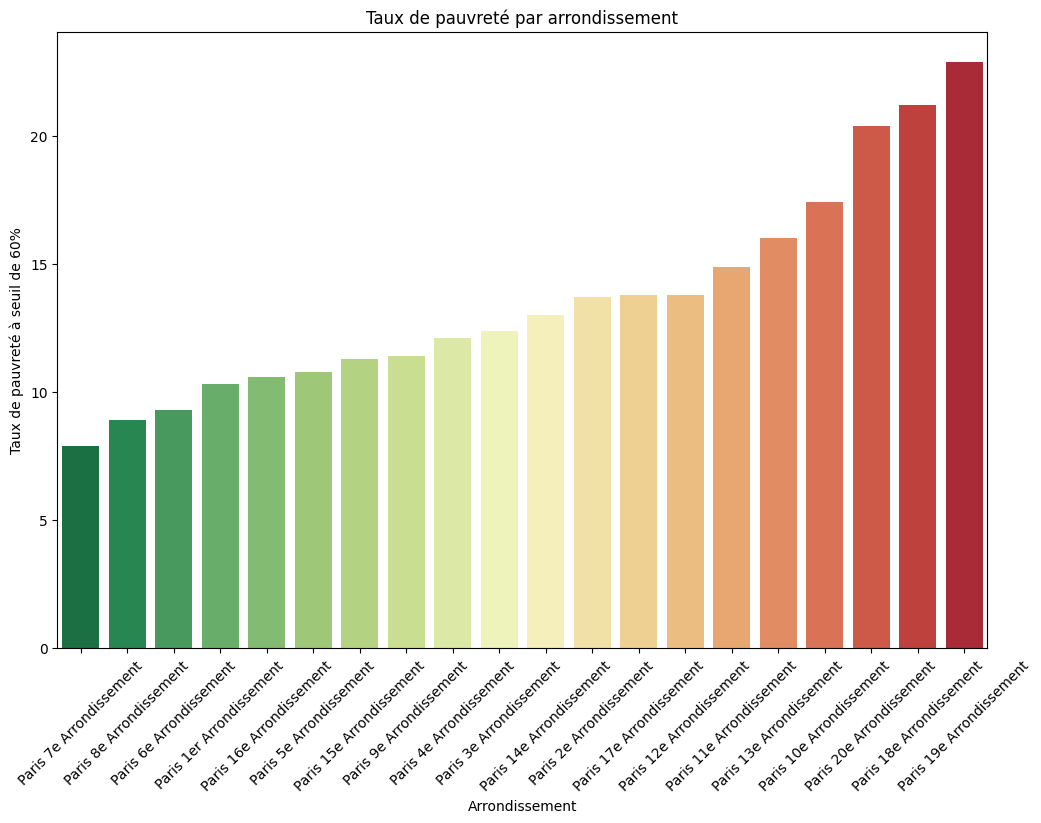

In [4]:
df_pauv_sorted = df_pauv_flt.sort_values('TP6017')
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='LIBGEO', y='TP6017', data=df_pauv_sorted, palette='RdYlGn_r')
plt.title('Taux de pauvreté par arrondissement')
plt.xlabel('Arrondissement')
plt.ylabel('Taux de pauvreté à seuil de 60%')
plt.xticks(rotation=45)

plt.show()


Le taux de bas revenus à 60% pour l'année 2017 dans les arrondissements Parisiens se trouvant dans la colonne "TP6017" est pris comme taux de pauvereté. Le graphe ci-dessus nous  donne la distribution de ce taux et le classement des arrondissements en fonction de leur taux de pauvereté.

## Importation d'une base sur les logements sociaux à Paris

Nous importons depuis une API de la ville de Paris une base contenant des informations sur les logements sociaux. Nous transformons le code postal en code INSEE grâce à la fonction *extraire_arrondissement* présente dans le fichier *fonctions.py* pour unifier les bases appliquons la même nomenclature que précedemment.

In [5]:
url_api_pauv = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/logements-sociaux-finances-a-paris/exports/json?select=code_postal,bs,nb_logmt_total,geo_shape"

try:
    response = requests.get(url_api_pauv)
    response.raise_for_status()
    wb = response.json()
except requests.exceptions.RequestException as e:
    print(f"Erreur lors de la requête : {e}")
except ValueError:
    print("Erreur : Impossible de décoder le JSON.")


df_log = pd.DataFrame(wb)

%run fonctions.py
df_log['code_postal'] = df_log['code_postal'].apply(extraire_arrondissement)

df_log = df_log.rename(columns={
    'code_postal': 'INSEE_COG',
})

In [6]:
df_log.head()

,INSEE_COG,bs,nb_logmt_total,geo_shape
0,75113,RIVP,23,"{'type': 'Feature', 'geometry': {'coordinates'..."
1,75118,ELOGIE SIEMP,2,"{'type': 'Feature', 'geometry': {'coordinates'..."
2,75118,PARIS HABITAT,25,"{'type': 'Feature', 'geometry': {'coordinates'..."
3,75109,PARIS HABITAT,15,"{'type': 'Feature', 'geometry': {'coordinates'..."
4,75113,ELOGIE SIEMP,9,"{'type': 'Feature', 'geometry': {'coordinates'..."


## Statistiques descriptives

Pour chaque arrondissement, les logements sociaux peuvent être financés par plusieurs organismes contenus dans la colonne "bs" , il faut donc compter le nombre total de logements financés grâce à la fonction *value_counts* pour pouvoir obtenir un graphe ordonné du nombre de logements sociaux par arrondissement. Nous effectuons ensuite une représentation cartographique grâce aux coordonnées de ces logements contenus dans la colonne "geo_shape"

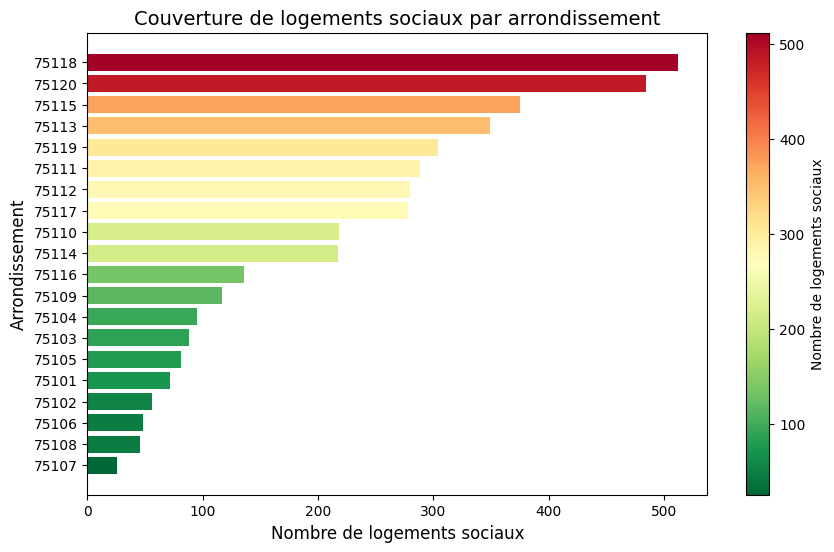

In [14]:
nb_log = df_log['INSEE_COG'].value_counts()
nb_log_sorted = nb_log.sort_values()
norm = mcolors.Normalize(vmin=nb_log_sorted.min(), vmax=nb_log_sorted.max())
cmap = plt.cm.RdYlGn_r
colors = [cmap(norm(value)) for value in nb_log_sorted]
plt.figure(figsize=(10, 6))
ax = plt.gca()  
plt.barh(nb_log_sorted.index, nb_log_sorted.values, color=colors)
plt.xlabel("Nombre de logements sociaux", fontsize=12)
plt.ylabel("Arrondissement", fontsize=12)
plt.title("Couverture de logements sociaux par arrondissement", fontsize=14)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 
cbar = plt.colorbar(sm, ax=ax, label="Nombre de logements sociaux")

plt.show()

In [13]:
df_log['nb_log'] = df_log['INSEE_COG'].map(nb_log)

In [22]:
df_log['geometry'] = df_log['geo_shape'].apply(lambda x: Point(x['geometry']['coordinates']))
gdf_log = gpd.GeoDataFrame(df_log, geometry='geometry', crs="EPSG:4326")

m = folium.Map(location=[48.8566, 2.3522], zoom_start=12)
for _, row in gdf_log.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=0.5,
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(m)

display(m)


## Importation de la base sur le nombre de commerces à Paris

In [22]:
url_api_commerces = "http://data.iledefrance.fr/explore/dataset/les-commerces-par-commune-ou-arrondissement-base-permanente-des-equipements/download?format=csv"

response2 = requests.get(url_api_commerces)
response2.raise_for_status() 

path_to_csv = "/tmp/data.csv"
with open(path_to_csv, 'wb') as file:
    file.write(response2.content)

df_commerces = pd.read_csv(path_to_csv, sep=';')
df_commerces = df_commerces[df_commerces['departement'] == 75]

In [23]:
df_commerces.head()

,departement,departement_commune,libelle_de_commune,arrondissement,canton_ville,zone_d_emploi,unite_urbaine,population_2010,hypermarche,supermarche,...,magasin_d_articles_de_sports_et_de_loisirs,magasin_de_revetements_murs_et_sols,droguerie_quincaillerie_bricolage,parfumerie,horlogerie_bijouterie,fleuriste,magasin_d_optique,station_service,geo_point_2d,geo_shape
58,75,75117,Paris 17e Arrondissement,751,7599,1101,851,169325,2,29,...,37,16,27,63,46,77,73,4,"48.88733716648682,2.307485559493426","{""coordinates"": [[[2.295145331385798, 48.87386..."
82,75,75106,Paris 6e Arrondissement,751,7599,1101,851,43451,0,7,...,12,12,7,41,67,26,44,0,"48.84896809191946,2.332670898588416","{""coordinates"": [[[2.336591298996422, 48.83969..."
83,75,75116,Paris 16e Arrondissement,751,7599,1101,851,171124,4,26,...,23,19,24,72,69,70,69,10,"48.86039876035177,2.262099559395783","{""coordinates"": [[[2.262784637049641, 48.83392..."
185,75,75105,Paris 5e Arrondissement,751,7599,1101,851,60938,0,6,...,39,5,13,20,20,30,29,1,"48.844508659617546,2.349859385560182","{""coordinates"": [[[2.365944019143637, 48.84490..."
243,75,75120,Paris 20e Arrondissement,751,7599,1101,851,196880,2,34,...,9,7,22,34,30,45,50,4,"48.86318677744551,2.400819826729021","{""coordinates"": [[[2.415973775474602, 48.84662..."


Cette base contient plusieurs colonnes énumérant les catégories de commerces et le nombre par catégorie dans chaque arrondissement. La catégorie n'étant pas importante danas notre étude, nous effectuons la somme de ces colonnes et stockons les informations dans la colonne "total_commerces"

In [30]:
df_commerces = df_commerces.rename(columns={
    'departement_commune': 'INSEE_COG',
})
df_commerces.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 58 to 1273
Data columns (total 34 columns):
 #   Column                                          Non-Null Count  Dtype 
---  ------                                          --------------  ----- 
 0   departement                                     20 non-null     int64 
 1   INSEE_COG                                       20 non-null     int64 
 2   libelle_de_commune                              20 non-null     object
 3   arrondissement                                  20 non-null     int64 
 4   canton_ville                                    20 non-null     int64 
 5   zone_d_emploi                                   20 non-null     int64 
 6   unite_urbaine                                   20 non-null     int64 
 7   population_2010                                 20 non-null     int64 
 8   hypermarche                                     20 non-null     int64 
 9   supermarche                                     20 non-nul

In [26]:
start = df_commerces.columns.get_loc("hypermarche")
end = df_commerces.columns.get_loc("station_service")

df_commerces['total_commerces'] = df_commerces.iloc[:, start:end+1].sum(axis=1)
df_commerces['total_commerces']

58      1644
82      1393
83      1577
185      754
243     1191
301     1478
428      763
519     1262
543     1713
729     1095
747     1654
822     1707
863      899
916     1029
936     1383
956      917
1141     857
1192    1395
1263     812
1273     881
Name: total_commerces, dtype: int64

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_4475/2438364987.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='libelle_de_commune', y='total_commerces', data=df_com_sorted, palette='RdYlGn')


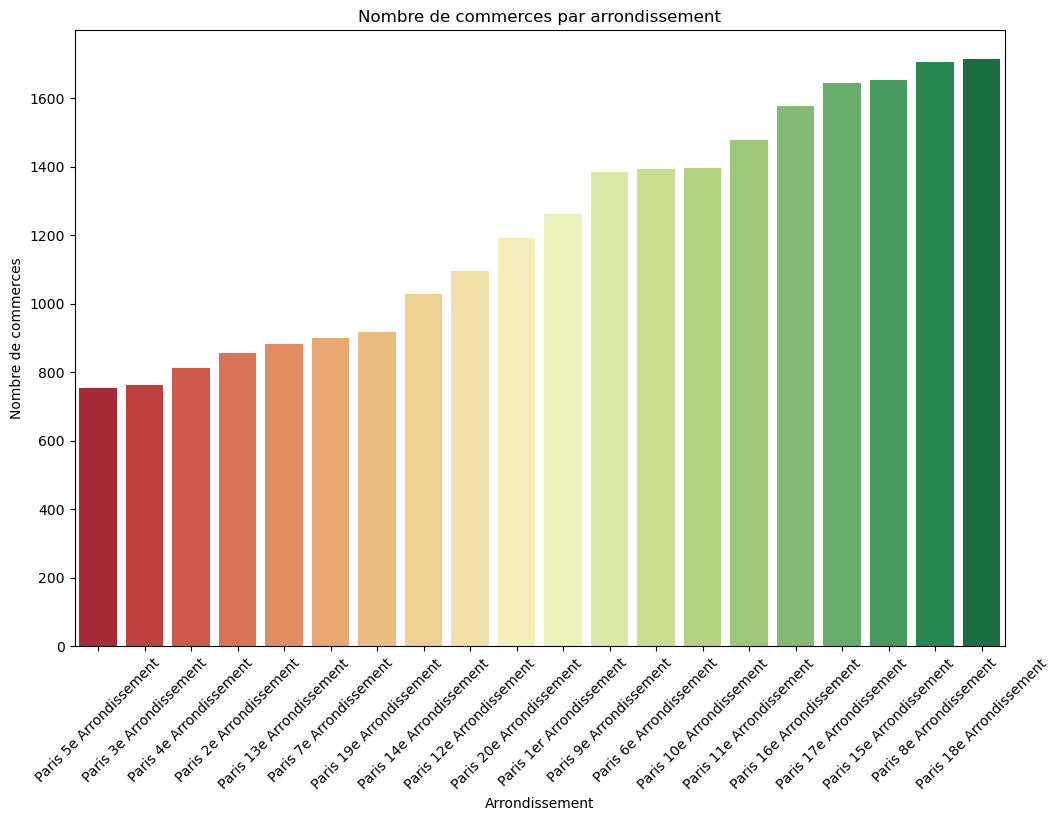

In [29]:
df_com_sorted = df_commerces.sort_values('total_commerces')
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='libelle_de_commune', y='total_commerces', data=df_com_sorted, palette='RdYlGn')
plt.title('Nombre de commerces par arrondissement')
plt.xlabel('Arrondissement')
plt.ylabel('Nombre de commerces')
plt.xticks(rotation=45)

plt.show()